In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm

#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10

## Collecting the data

In [39]:
clusters_z0p00_file = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/' + 'MDPL2_halos_DS_Ngal_Dgal_lt_2_allM_mah_z0p00.p'

In [40]:
with open(clusters_z0p00_file, 'rb') as handle:
    matched_halo_df = pickle.load(handle)

In [41]:
matched_halo_df.columns

Index(['scale', 'id', 'pid', 'mvir', 'rvir', 'x', 'y', 'z', 'M200b', 'M200c',
       'M500c', 'Type', 'GalaxyIndex', 'CentralGalaxyIndex', 'CtreesHaloID',
       'CtreesCentralID', 'CentralMvir', 'StellarMass', 'Ngal', 'cluster_id',
       'sigma', 'r_range', 'delta_sigma', 'rs', 'T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir'],
      dtype='object')

## Initiating the variables. 

What is it that we want to do. 

Build a linear regression model to explain DeltaSigma in the inner bin as a function of mass and formation time history

In [42]:
display(matched_halo_df[['mvir','M200b','T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir']].corr())

,mvir,M200b,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir
mvir,1.000000,0.996716,0.238452,0.196192,0.358387,0.358387,0.613766,0.793756,0.883615,-0.203265
M200b,0.996716,1.000000,0.231508,0.179047,0.366252,0.366252,0.589850,0.774323,0.871444,-0.212097
T/|U|,0.238452,0.231508,1.000000,0.642274,0.455129,0.455129,0.613005,0.473223,0.393809,-0.396614
Halfmass_Scale,0.196192,0.179047,0.642274,1.000000,0.237599,0.237599,0.464309,0.515517,0.468765,-0.575582
Acc_Rate_Inst,0.358387,0.366252,0.455129,0.237599,1.000000,1.000000,0.595898,0.430620,0.373494,-0.231633
Acc_Rate_100Myr,0.358387,0.366252,0.455129,0.237599,1.000000,1.000000,0.595898,0.430620,0.373494,-0.231633
Acc_Rate_1*Tdyn,0.613766,0.589850,0.613005,0.464309,0.595898,0.595898,1.000000,0.832721,0.704172,-0.202996
Acc_Rate_2*Tdyn,0.793756,0.774323,0.473223,0.515517,0.430620,0.430620,0.832721,1.000000,0.924943,-0.362376
Acc_Rate_Mpeak,0.883615,0.871444,0.393809,0.468765,0.373494,0.373494,0.704172,0.924943,1.000000,-0.356966
c_vir,-0.203265,-0.212097,-0.396614,-0.575582,-0.231633,-0.231633,-0.202996,-0.362376,-0.356966,1.000000


In [43]:
DS_inner = matched_halo_df['delta_sigma']
DS_inner = np.vstack(DS_inner)
DS_inner = DS_inner[:,0]

In [44]:
DS_inner

array([3.81996305e+14, 3.57658284e+14, 4.51919098e+14, ...,
       6.68543339e+14, 5.57680755e+14, 6.52687184e+14])

In [45]:
Mvir = np.log10(matched_halo_df['mvir'])
acc_rate = matched_halo_df['Acc_Rate_2*Tdyn']
richness = matched_halo_df['Ngal']

In [80]:
cur_df = matched_halo_df[(matched_halo_df.mvir > 5e13) & (matched_halo_df.mvir < 1e14)]

cur_df['logM'] = np.log10(M200b)


X = cur_df[['logM', 'Halfmass_Scale', 'T/|U|', 'c_vir', 'Acc_Rate_Mpeak']]
#X = cur_df['Halfmass_Scale']

DS_inner = cur_df['delta_sigma']
DS_inner = np.vstack(DS_inner)
DS_inner = DS_inner[:,0]
y = DS_inner


print(np.size(X))
print(np.size(y))

1835
367


/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
X = sm.add_constant(X)
mreg = sm.OLS(y, X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     81.75
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           3.16e-57
Time:                        09:21:37   Log-Likelihood:                -12217.
No. Observations:                 367   AIC:                         2.445e+04
Df Residuals:                     361   BIC:                         2.447e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.987e+15   1.95e+15     -4.608      0.000   -1.28e+16   -5.15e+15
logM            8.259e+15    1.7e+15      4.852      0.000    4.91e+15    1.16e+16
Halfmass_Scale -1.159e+14   6.17e+13     -1.877      0.061   -2.37e+14    5.54e+12
T/|U|          -1.787e+14   7.37e+13     -2.426      0.016   -3.24e+14   -3.38e+13
c_vir           2.535e+13   2.14e+12     11.858      0.000    2.11e+13    2.96e+13
Acc_Rate_Mpeak -1.191e+08   2.44e+09     -0.049      0.961   -4.92e+09    4.68e+09
==============================================================================
Omnibus:                       34.930   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.998
Skew:                           0.751   Prob(JB):                     4.60e-10
Kurtosis:                       3.746   Cond. No.                     4.62e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
ssr = np.sum((mreg.fittedvalues - np.mean(y))**2)
ssr

1.13365723560578e+30

## Testing for multi-linearity

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


print(checking_vif(X))

          feature            VIF
0           const  285151.564064
1            logM       1.508586
2  Halfmass_Scale       4.023963
3           T/|U|       1.738054
4           c_vir       1.657918
5  Acc_Rate_Mpeak       3.713275


## Heterodescity

In [83]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(y, X)
lzip(name, test)

[('F statistic', 0.934579086155291), ('p-value', 0.6735991002223829)]

## Check that residual is 0

In [84]:
residuals = mreg.resid
residuals.mean()

-21749.264560626703

## Linearity

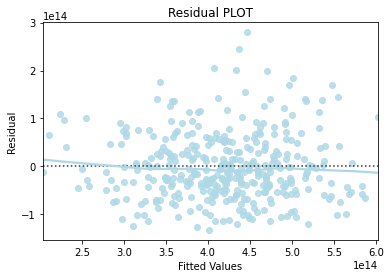

In [85]:
# predicted values
fitted = mreg.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color="lightblue", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

## Gaussian error

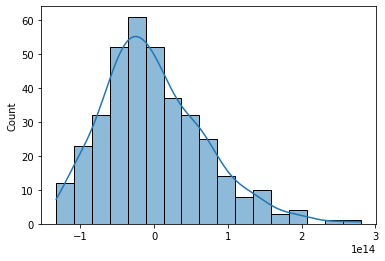

In [86]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

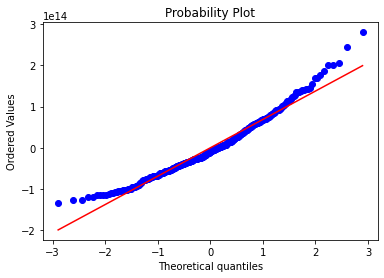

In [87]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

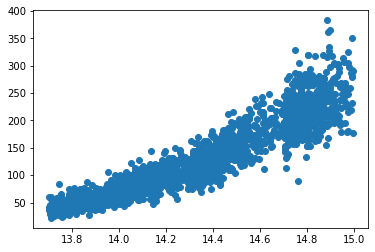

In [88]:
plt.scatter(Mvir, richness) 
plt.show()

/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


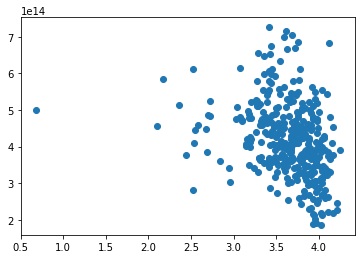

In [89]:
plt.scatter(np.log10(cur_df['Acc_Rate_2*Tdyn']), y) 
plt.show()

## Formation time alone

In [90]:
X_formation = cur_df[['Halfmass_Scale', 'T/|U|', 'c_vir', 'Acc_Rate_Mpeak']]


print(np.size(X))
print(np.size(y))

2202
367


In [91]:
X_formation = sm.add_constant(X_formation)
mreg_formation = sm.OLS(y, X_formation).fit()
display(mreg_formation.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     90.66
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           2.56e-53
Time:                        09:36:04   Log-Likelihood:                -12229.
No. Observations:                 367   AIC:                         2.447e+04
Df Residuals:                     362   BIC:                         2.449e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.727e+14   4.96e+13      9.532      0.000    3.75e+14     5.7e+14
Halfmass_Scale -2.501e+14   5.69e+13     -4.397      0.000   -3.62e+14   -1.38e+14
T/|U|          -1.486e+14   7.57e+13     -1.963      0.050   -2.97e+14    2.37e+11
c_vir           2.566e+13    2.2e+12     11.647      0.000    2.13e+13       3e+13
Acc_Rate_Mpeak  6.622e+09   2.07e+09      3.204      0.001    2.56e+09    1.07e+10
==============================================================================
Omnibus:                       34.412   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.858
Skew:                           0.730   Prob(JB):                     4.94e-10
Kurtosis:                       3.820   Cond. No.                     1.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
ssr_formation = np.sum((mreg_formation.fittedvalues - np.mean(y))**2)
ssr_formation

1.8856662426228662e+30

## Mass alone

In [93]:
X_mass = cur_df[['logM']]

In [94]:
X_mass = sm.add_constant(X_mass)
mreg_mass = sm.OLS(y, X_mass).fit()
display(mreg_mass.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     10.56
Date:                Wed, 07 Sep 2022   Prob (F-statistic):            0.00126
Time:                        09:36:06   Log-Likelihood:                -12351.
No. Observations:                 367   AIC:                         2.471e+04
Df Residuals:                     365   BIC:                         2.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.948e+15   2.27e+15     -3.065      0.002   -1.14e+16   -2.49e+15
logM        6.448e+15   1.98e+15      3.250      0.001    2.55e+15    1.03e+16
==============================================================================
Omnibus:                        4.776   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.517
Skew:                           0.258   Prob(JB):                        0.104
Kurtosis:                       3.173   Cond. No.                         875.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
ssr_mass = np.sum((mreg_mass.fittedvalues - np.mean(y))**2)
ssr_mass

1.0599131434567733e+29

## Partitioning Sum of Squares
* Total: 24.02
* SS Mass (unique): 24.02 - 14.66 = 9.36
* SS Formation time history (unique): 24.02 - 17.02 = 7.00
* SS Confounded: 7.66

## Testing the regression on the number count. 